<a href="https://colab.research.google.com/github/CuadraAlconero/IDAL_IA3_CuadraAlconero/blob/main/Ejercicio_Jumanji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

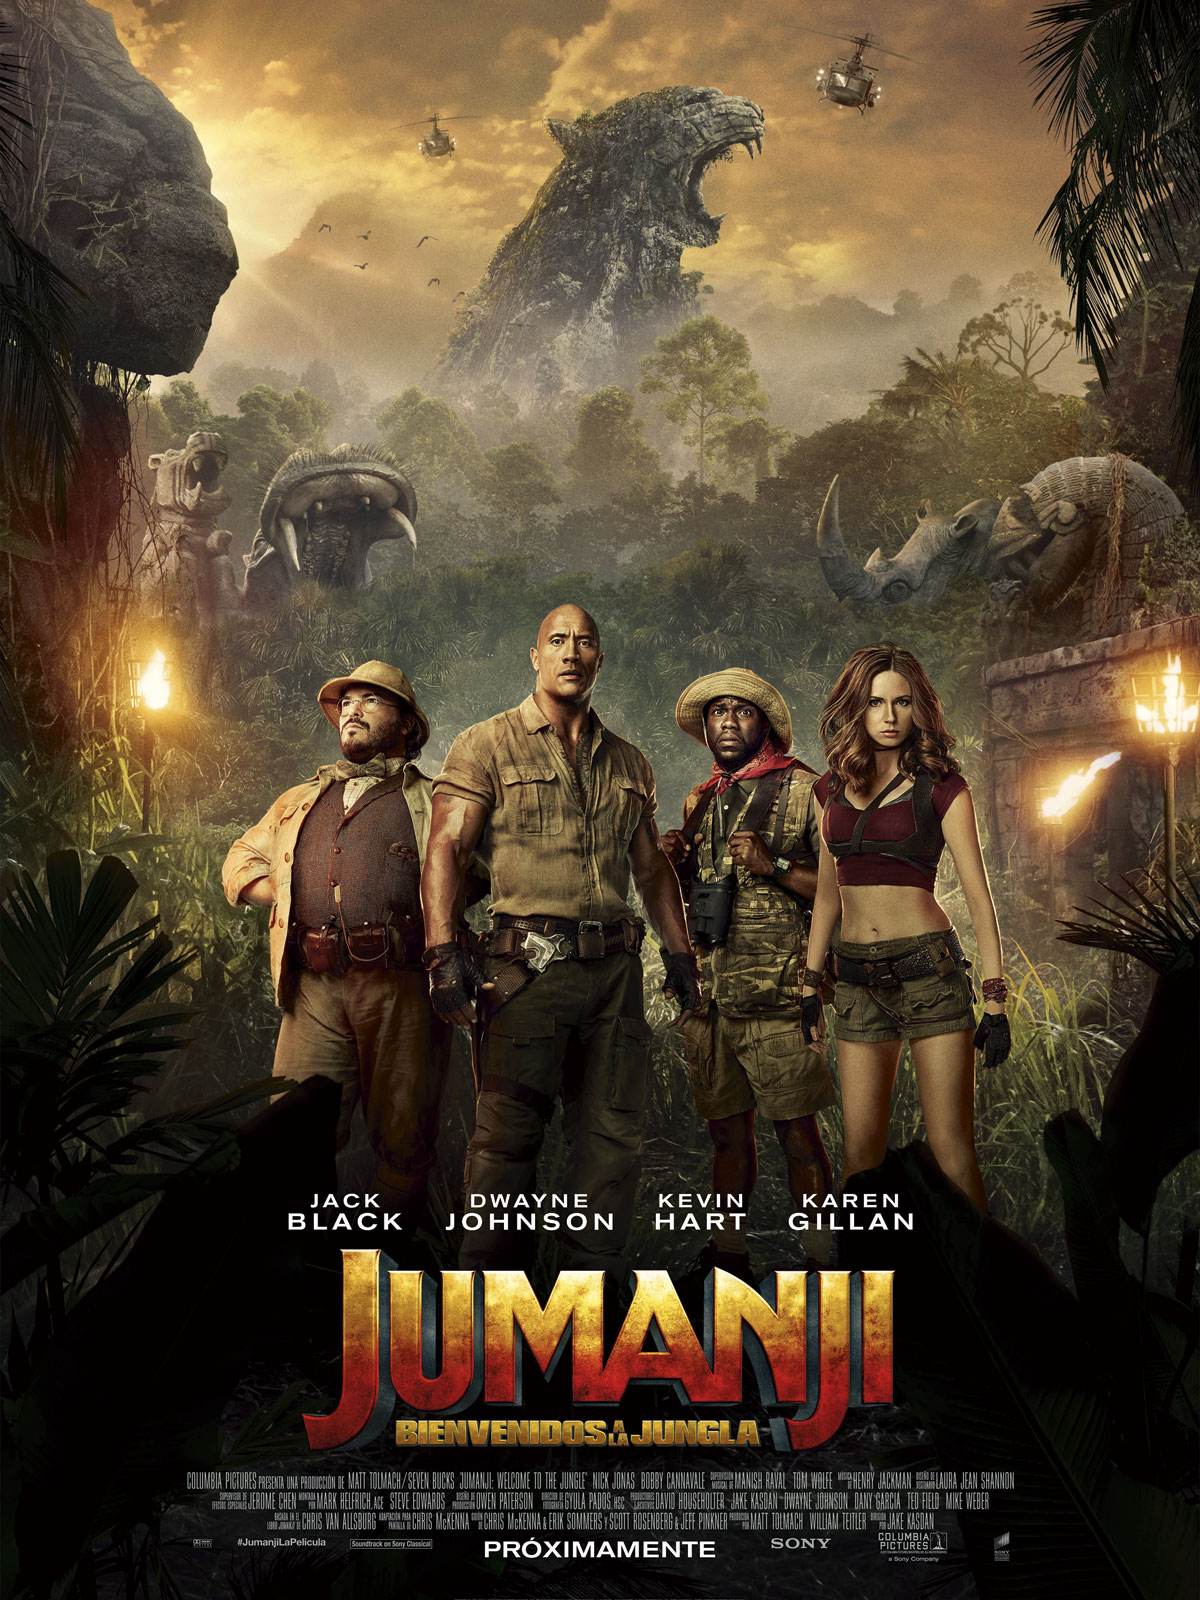

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

In [ ]:
COLAB = True

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from PIL import Image
import os
import numpy as np
import pandas as pd
from random import shuffle
import random
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
IMAGE_W = IMAGE_H = 128
batch_size = 32

train_folder = "cats_and_dogs_filtered/train"
validation_folder = "cats_and_dogs_filtered/validation"


# PreProcessing Pipeline

In [ ]:
from PIL import ImageFilter,ImageOps

class ImagePre:
    def __init__(self,shape,max_rotate=30):
        self.shape = shape
        self.max_rotate = max_rotate
        self.filters = ["blur","sharpen","smooth","mirror","spread","rotate"]
        
        
    def augmentation(self,img,effect="random"):

        if effect == "random": effect = random.choice(self.filters)
        
        if effect == "rotate":
            angle = random.randint(-self.max_rotate,self.max_rotate)
            img = img.rotate(angle)
            return img
        
        if effect == "blur":
            img = img.filter(ImageFilter.BLUR)
            return img
        
        if effect == "sharpen":
            img = img.filter(ImageFilter.SHARPEN)
            return img
        
        if effect == "smooth":
            img = img.filter(ImageFilter.SMOOTH)
            return img
        
        if effect == "mirror":
            img = ImageOps.mirror(img)
            return img
        
        if effect == "spread":
            img = img.effect_spread(3)
            return img
        
        return None
    
    
    def pad_image(self, img):
        width, height = img.size
        desired_resolution = self.shape[0]
        array = np.array(img)
        
        if width > height:
          total_pad = desired_resolution - height
          pad_index = 0
        else:
          total_pad = desired_resolution - width
          pad_index = 1  
            
        pad = total_pad/2
        pad_0 = int(np.ceil(pad))
        pad_1 = int(np.floor(pad))
        pad_pattern = [ (0,0),(0,0),(0,0) ]
        pad_pattern[pad_index] = (pad_0,pad_1)
        padded_image = np.pad(array, pad_pattern )
        
        return padded_image


    def change_resolution(self, img):
        desired_resolution = self.shape[0]
        width, height = img.size
        if width > height:
          aspect_relatio = width/height
          new_width = desired_resolution
          new_height = round(desired_resolution/aspect_relatio)
          resized_img = img.resize((new_width,new_height))
        else:
          aspect_relatio = height/width
          new_height = desired_resolution
          new_width = round(desired_resolution/aspect_relatio)
          resized_img = img.resize((new_width,new_height))
            
        return resized_img
    
    def resize_no_padding(self,img):
        # resize the image and crop the excess
        width,height = img.size
        final_size = self.shape[0]
        if width<height:
            aspect = final_size/width
        else:
            aspect = final_size/height
        width = int(np.ceil(width*aspect))
        height = int(np.ceil(height*aspect))
        
        assert width>=final_size,"Width error"
        assert height>=final_size,"Height error"
        
        img = img.resize( (width,height))
        img = img.crop( (0,0,final_size,final_size))
        
        return img
    
        


# Data Augmentation

In [ ]:
class ImageSequence(Sequence):
    
  def __init__(self, data_folder, img_shape, batch_size=32, augmentation=True,aug_effect="random",to_fit=True):
    self.data_folder = data_folder
    self.files = [os.path.join(path, name) for path, subdirs, files in os.walk(data_folder) for name in files]
    shuffle(self.files)
    self.labels = self._generate_Y(self.files)
    self.batch_size = batch_size
    self.augmentation = augmentation
    self.aug_effect = aug_effect
    self.batches = int( np.floor( len(self.files) / self.batch_size))       
    self.shape = img_shape
    self.to_fit = to_fit
    self.img_pre = ImagePre(img_shape)
    self.batch_cache = [None]*self.batches

  def __len__(self):
    return self.batches

  def __getitem__(self, index):
    X = self._generate_X(index)    
    if self.to_fit:
      first_file = index*self.batch_size
      last_file = first_file + self.batch_size
      y = self.labels[first_file:last_file]
      return X,y
    else:
      return X

  def _generate_X(self, index):
        
    shape = [self.batch_size,*self.shape,3]
            
    if self.batch_cache[index] is not None:
        images = self.batch_cache[index]
    else:
        first_file = index*self.batch_size
        last_file = first_file + self.batch_size
        files = self.files[first_file: last_file]    
        images = []
        for i, file_ in enumerate(files):
          img = Image.open(file_)
          img = self.img_pre.resize_no_padding(img)
          images.append(img)
          #resize_image = self.img_pre.change_resolution(img)
          #final_image = self.img_pre.pad_image(resize_image)
        self.batch_cache[index] = images
    
    X = np.zeros(shape=shape)
        
    for i,img in enumerate(images):
        if self.augmentation:
            img = self.img_pre.augmentation(img,self.aug_effect)            
        X[i, :, :, :] = np.array(img,dtype=np.float32)/255
       
    return X

  
  def _generate_Y(self, batch_files):
    y = list()
    for file_ in batch_files:
      label = file_.split("/")
      y.append(label[2])
    arr = np.array(y)
    return arr=="dogs"

    df_labels = pd.DataFrame(y)
    y_dummies = pd.get_dummies(df_labels).values
    return y_dummies

    

In [ ]:
random.seed(1234)
train_generator = ImageSequence(train_folder, (IMAGE_H,IMAGE_W), batch_size=batch_size, augmentation=True,aug_effect="random")
validation_generator = ImageSequence(validation_folder, (IMAGE_H,IMAGE_W),batch_size=batch_size,augmentation=False)



# Best Model
In order to create this model we used the technique called Transfer Learning which allowed us to build a model based on an existing architecture. This architecture is called Resnet50. It is well known for being an stable and robust model which offers good results when processing datasets with images. From this existing architecture we took advantage of its features extraction layers and added a customized classification stage.

In [ ]:
pre_dims = IMAGE_H,IMAGE_W

In [ ]:
pre_dims + (3,)

(128, 128, 3)

In [ ]:
#transfer learning: importing the based model (Resnet50)

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
base_model = ResNet50(include_top=False, input_shape=pre_dims + (3,))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = True #Here we adjust the settings for the based model's weights being adjusted by the backpropagation.

In [ ]:
len(base_model.layers)

175

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from glob import glob
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

Here it comes our customised classification stage:

In [ ]:
layer_base = base_model.output
layer1 = GlobalAveragePooling2D()(layer_base)
layer2 = Flatten(data_format="channels_last")(layer_base)

layer3 = Dropout(0.1)(layer2)
layer4 = Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.01))(layer3)

layer5 = Dropout(0.01)(layer4)
layer6 = Dense(8, activation="relu")(layer5)

classifier = Dense(1, activation="sigmoid")(layer6)


In [ ]:

model = Model(inputs=base_model.input, outputs=classifier)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
model.summary()

We prepare the training for our model, and introduce the option of saving the best version of our model during the training.

In [ ]:
modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1,
                              save_best_only=True,
                              mode='max')


We train the model during 50 epoches and check the results.

In [ ]:
history = model.fit(train_generator, epochs=50 ,validation_data=validation_generator, callbacks = [checkpoint])


Epoch 1/50
62/62 [==============================] - 12s 190ms/step - loss: 0.6694 - accuracy: 0.6134 - val_loss: 0.6294 - val_accuracy: 0.6462
Epoch 2/50
62/62 [==============================] - 12s 189ms/step - loss: 0.6610 - accuracy: 0.6280 - val_loss: 0.6382 - val_accuracy: 0.6573
Epoch 3/50
62/62 [==============================] - 12s 189ms/step - loss: 0.6491 - accuracy: 0.6477 - val_loss: 0.6247 - val_accuracy: 0.6603
Epoch 4/50
62/62 [==============================] - 12s 190ms/step - loss: 0.6421 - accuracy: 0.6371 - val_loss: 0.6232 - val_accuracy: 0.6573
Epoch 5/50
62/62 [==============================] - 12s 190ms/step - loss: 0.6394 - accuracy: 0.6366 - val_loss: 0.6625 - val_accuracy: 0.6149
Epoch 6/50
62/62 [==============================] - 12s 189ms/step - loss: 0.6586 - accuracy: 0.6316 - val_loss: 0.6207 - val_accuracy: 0.6562
Epoch 7/50
62/62 [==============================] - 12s 189ms/step - loss: 0.6590 - accuracy: 0.6401 - val_loss: 0.6322 - val_accuracy: 0.6562

Displaying the training results

In [ ]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i, figsize=(10,4)):
  from matplotlib.ticker import MaxNLocator
  plt.figure(figsize=figsize)
  ax = plt.subplot(1,2,1)
  plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
  plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
  plt.plot(1+best_i, 100*val_acc[best_i], 'or')
  plt.title('tasa de acierto del modelo (%)', fontsize=18)
  plt.ylabel('tasa de acierto (%)', fontsize=18)
  plt.xlabel('época', fontsize=18)
  plt.legend(['entrenamiento', 'validación'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  plt.subplot(1,2,2)
  plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
  plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
  plt.plot(1+best_i, val_loss[best_i], 'or')
  plt.title('loss del modelo', fontsize=18)
  plt.ylabel('loss', fontsize=18)
  plt.xlabel('época', fontsize=18)
  plt.legend(['entrenamiento', 'validación'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.show()

acum_val_acc:  0.6673387289047241


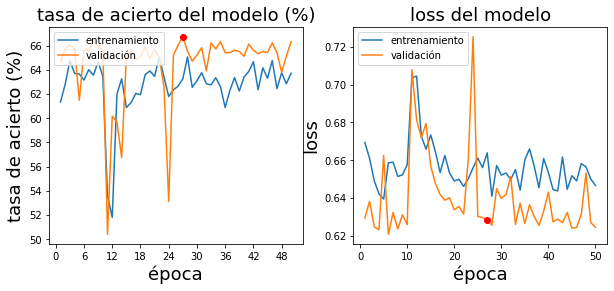

In [ ]:
best_i = np.argmax(history.history['val_accuracy'])
print('acum_val_acc: ',history.history['val_accuracy'][best_i])
grafica_entrenamiento(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'], best_i=best_i)

We can see on the graphic that the best model version was achieved around epoche No. 25. In addition, the graphic also shows how the trainig results and the validation results are quite similar most of the time. Therefore, we can conclude that there is no overfitting either. 

In order to get more information about our architecture, we are going to display the ROC curve.

In [ ]:
y_pred_proba = model.predict(validation_generator)
y_real = validation_generator.labels[0:y_pred_proba.shape[0]]

y_real.shape, y_pred_proba.shape

((992,), (992, 1))

In [ ]:
def plot_roc_curve(y_real, y_pred_proba):
  from sklearn.metrics import roc_curve, auc
  fpr, tpr, thresholds = roc_curve(y_real, y_pred_proba)
  fig, ax1 = plt.subplots(1, 1)
  ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.plot(fpr, fpr, 'b-')
  ax1.legend();

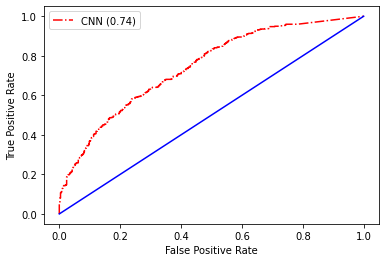

In [ ]:
plot_roc_curve(y_real, y_pred_proba)

# Loading Best Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

best_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Grupo 2/Jumanji/model_current_best_final.h5")

In [ ]:
model = best_model
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

62/62 [==============================] - 9s 128ms/step - loss: 0.1688 - accuracy: 0.9466
Train loss    : 0.16882027685642242
Train accuracy: 0.9465726017951965

31/31 [==============================] - 4s 129ms/step - loss: 0.3315 - accuracy: 0.9042
Val loss    : 0.33147376775741577
Val accuracy: 0.9042338728904724



After checking the best model scores, we confirm this model got the best scores with over 90% of accuracy for the validation dataset.

# Feature Maps 

In [ ]:
from tensorflow import keras 

model = best_model

def show_layer(model,layer_idx,batch_idx=0,img_idx=0,max_filters=16):
  if max_filters>16: max_filters = 16

  print("Layer:",layer_idx)
  input_layer = model.layers[0].input
  new_outputs = model.layers[layer_idx].output
  new_model = keras.Model(inputs=input_layer, outputs=new_outputs)
  X,y = validation_generator[batch_idx]
  prediction = new_model.predict(X)
  y_hat = model.predict(X)
  print("Layer shape:", prediction.shape)
  if type(img_idx)==list:
    images = img_idx
  else:
    images = [img_idx]
  for img in images:
    print("Label:", "dog" if y[img] else "cat")
    print("Prediction (is it a dog?):",  y_hat[img])
    plt.imshow(X[img])
    plt.show()
    plt.figure(figsize=(15, 15))
    n_filters = min(max_filters,prediction.shape[3])
    for idx in range(n_filters):
      plt.subplot(4,4,idx+1)
      filter = prediction[img,:,:,idx]
      plt.imshow(filter, cmap="viridis")
    plt.show()
    print("-------------------------------------------------------------------------------------------------")

Layer: 1
Layer shape: (32, 134, 134, 3)
Label: dog
Prediction (is it a dog?): [0.99861026]


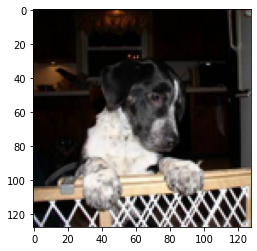

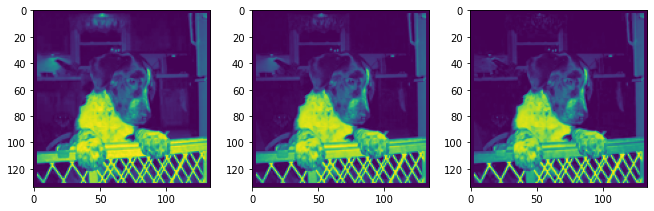

-------------------------------------------------------------------------------------------------
Label: cat
Prediction (is it a dog?): [0.00240821]


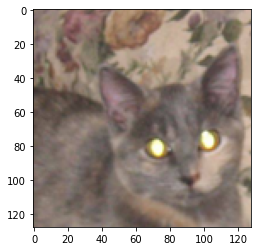

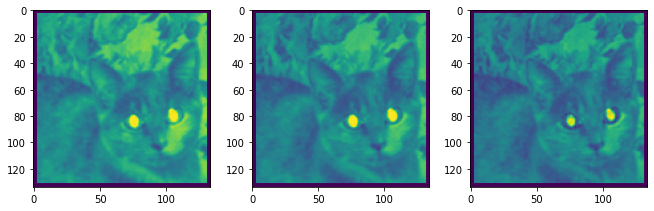

-------------------------------------------------------------------------------------------------
Label: dog
Prediction (is it a dog?): [0.99999535]


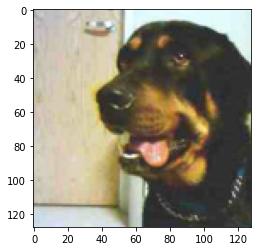

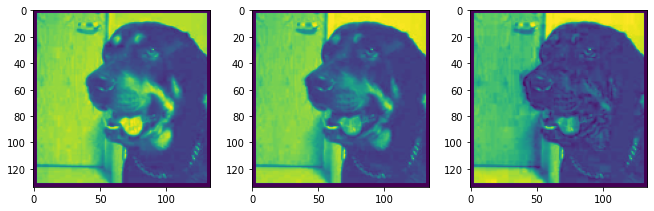

-------------------------------------------------------------------------------------------------
Label: dog
Prediction (is it a dog?): [0.8089997]


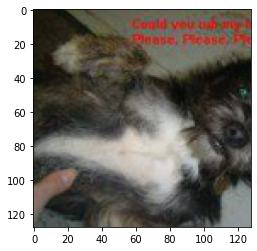

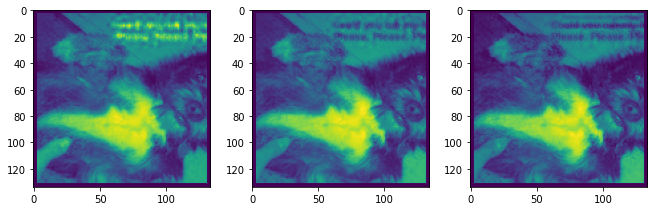

-------------------------------------------------------------------------------------------------
Label: dog
Prediction (is it a dog?): [0.99970067]


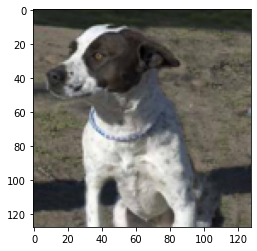

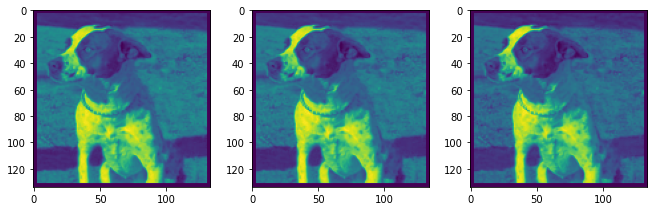

-------------------------------------------------------------------------------------------------


In [ ]:
show_layer(model,1,img_idx=[0,5,10,22,30])



Layer: 1
Layer shape: (32, 134, 134, 3)


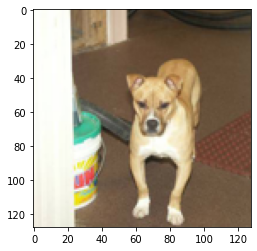

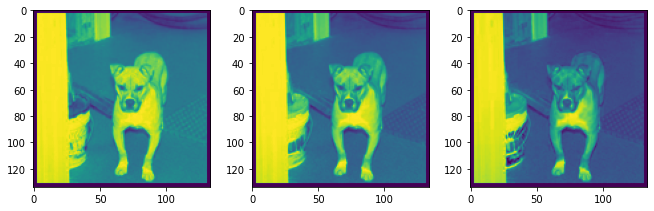

In [ ]:
show_layer(model,1,img_idx=15)

By comparing the different results of these images in layer[1], we noted that this feature focuses on highlighting the white colour. 
<br>
<br>
As we can see below, the deeper we check, the more unrecognizable the features are, until we can see just colours with no forms.  


Layer: 10
Layer shape: (32, 32, 32, 64)


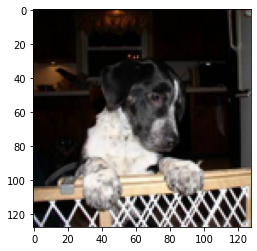

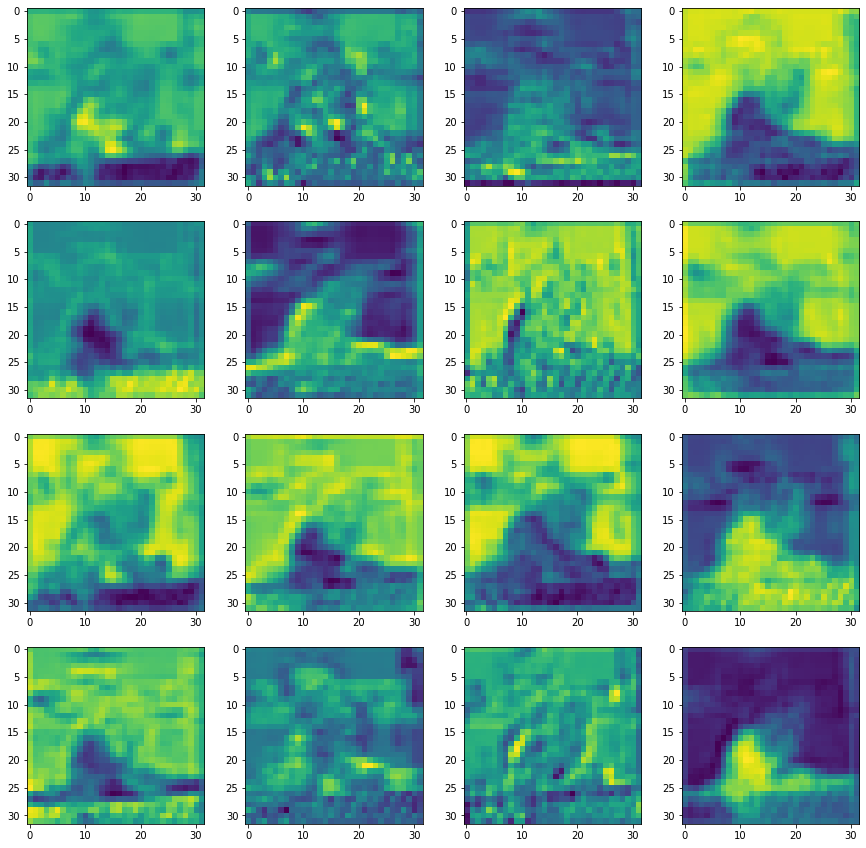

In [ ]:
show_layer(model,10)

(32, 32, 32, 256)


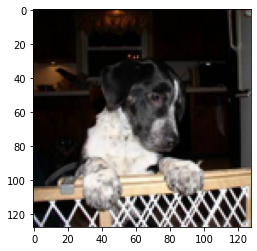

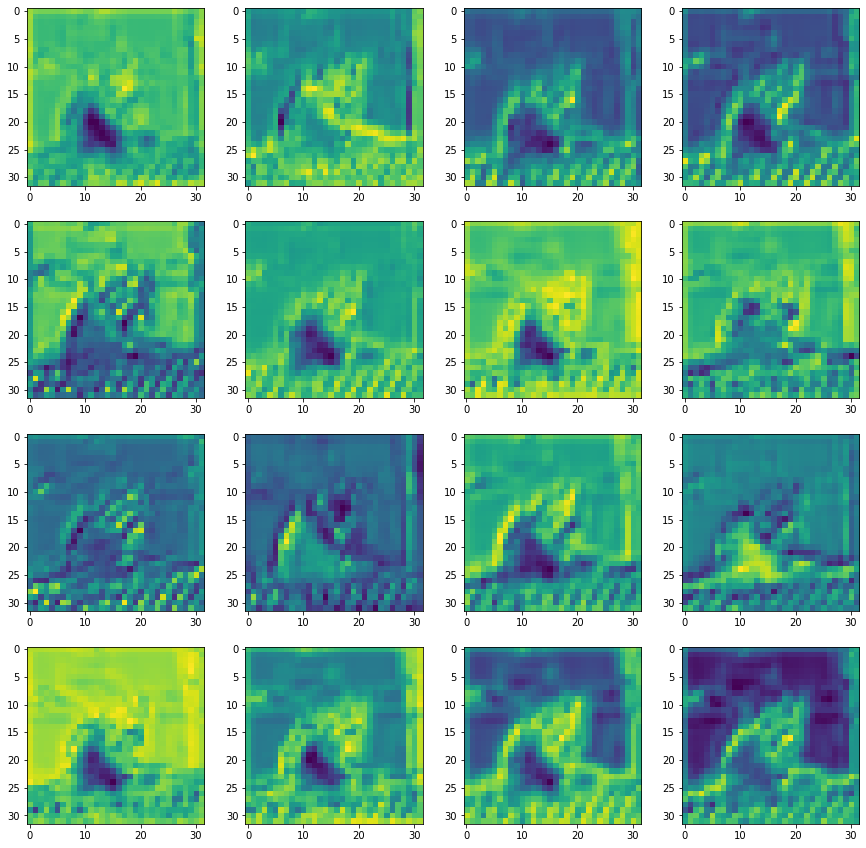

In [ ]:
show_layer(model,36)

Layer: 100
Layer shape: (32, 8, 8, 1024)


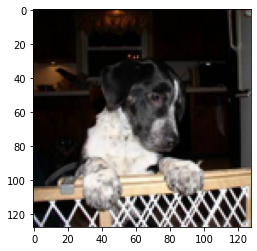

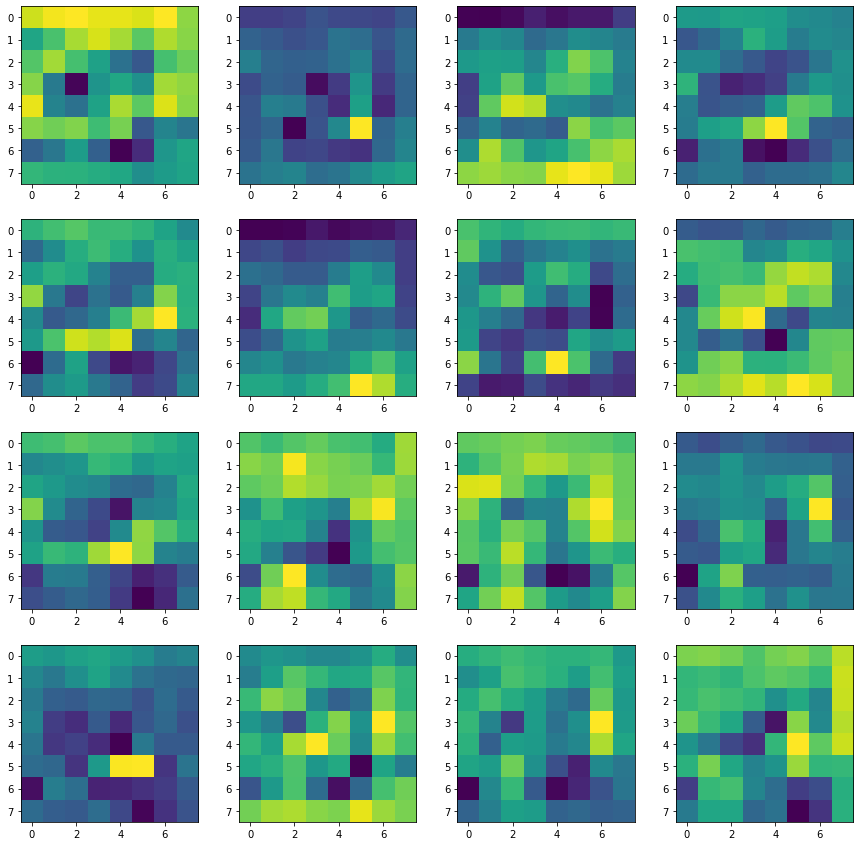

In [ ]:
show_layer(model,100)